# EEG Emotional Memory Classification - Starter Notebook

Welcome to the EEG Emotional Memory Reactivation Competition!

This notebook demonstrates:
1. Loading and processing training data
2. Extracting theta power features (4-8 Hz)
3. Leave-one-participant-out cross-validation (for local validation)
4. Training final model on all training data
5. Loading and processing test data
6. Making predictions on test set
7. Creating valid submission file

## 1. Setup and Imports

In [1]:
import numpy as np
import h5py
import os
import pandas as pd
import glob
from scipy.signal import hilbert, butter, filtfilt
from scipy.stats import zscore
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

print("All packages imported successfully")

All packages imported successfully


## 2. Configuration

On Kaggle, data is in `/kaggle/input/dataset-name/`

For local testing, adjust paths accordingly.

In [2]:
# data paths
if os.path.exists('/kaggle/input'):
    # running on Kaggle
    TRAIN_PATH = r'D:\Deep Learning & Time Series - predicting-emotions-using-brain-waves\training' 
    TEST_PATH = r'D:\Deep Learning & Time Series - predicting-emotions-using-brain-waves\testing'  # will exist on Kaggle when submitting
else:
    # running locally (if you want to download the notebook and work on your machine)
    TRAIN_PATH = r'D:\Deep Learning & Time Series - predicting-emotions-using-brain-waves\training'
    TEST_PATH = r'D:\Deep Learning & Time Series - predicting-emotions-using-brain-waves\testing'  # for local testing, pointing to the generated public data

## 3. Data Loading and Feature Extraction

we'll define the functions to load HDF5 files and extract power features

In [3]:
def load_hdf5_data(filepath):
    """
    load HDF5 MATLAB v7.3 file

    Parameters:
    -----------
    filepath : str
        path to .mat file

    Returns:
    --------
    data_dict : dict
        dictionary with 'trial', 'trialinfo', 'time'
    """
    def load_field(f, data_ref, field_name):
        """helper to load HDF5 field handling references"""
        field = data_ref[field_name]

        if isinstance(field, h5py.Dataset):
            ref_value = field[()]

            if isinstance(ref_value, h5py.Reference):
                return f[ref_value]
            elif hasattr(ref_value, 'shape') and ref_value.shape == (1, 1):
                ref = ref_value.item()
                if isinstance(ref, h5py.Reference):
                    return f[ref]
                else:
                    if isinstance(ref, bytes):
                        ref = ref.decode('utf-8')
                    return f[ref]
            else:
                return field
        else:
            return field

    with h5py.File(filepath, 'r') as f:
        data_ref = f['data']

        trial_data = load_field(f, data_ref, 'trial')
        try:
            trialinfo_data = load_field(f, data_ref, 'trialinfo')
            trialinfo = np.array(trialinfo_data).T
        except (KeyError, ValueError, TypeError):
            # trialinfo might be missing in public test data
            trialinfo = None

        time_data = np.array(load_field(f, data_ref, 'time')).flatten()
        trial_data = np.array(load_field(f, data_ref, 'trial')).T # (Trials, Channels, Time)

        # enforce 0 to 1s trim (in case input data is not trimmed)
        # we only keep time >= 0
        mask = time_data >= 0

        if np.any(~mask): # if there are negative timepoints
            time_data = time_data[mask]
            trial_data = trial_data[:, :, mask]
            # trialinfo is per trial, not per timepoint, so it stays same

        return {
            'trial': trial_data,
            'trialinfo': trialinfo,
            'time': time_data
        }

print("Data loading function defined")

Data loading function defined


In [4]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    apply Butterworth bandpass filter
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)


def extract_hilbert_power(data, freq_band=(4, 8), fs=200):
    """
    extract instantaneous power using Hilbert transform

    Parameters:
    -----------
    data : ndarray
        EEG data with shape (trials, channels, timepoints)
    freq_band : tuple
        frequency band to analyze (default: 4-8 Hz theta)
    fs : float
        sampling frequency (default: 200 Hz)

    Returns:
    --------
    power : ndarray
        instantaneous power, same shape as input
    """
    n_trials, n_channels, n_timepoints = data.shape

    # bandpass filter
    data_filtered = np.zeros_like(data)
    for trial in range(n_trials):
        for ch in range(n_channels):
            data_filtered[trial, ch, :] = butter_bandpass_filter(
                data[trial, ch, :], freq_band[0], freq_band[1], fs
            )

    # hilbert transform
    analytic_signal = np.zeros(data_filtered.shape, dtype=complex)
    for trial in range(n_trials):
        for ch in range(n_channels):
            analytic_signal[trial, ch, :] = hilbert(data_filtered[trial, ch, :])

    # extract power
    power = np.abs(analytic_signal) ** 2

    return power

print("Feature extraction functions defined")

Feature extraction functions defined


## 4. Load Training Data

load all training participants (14 participants)

In [5]:
print("="*70)
print("LOADING TRAINING DATA")
print("="*70)

# find all training files
neu_path = os.path.join(TRAIN_PATH, 'sleep_neu')
train_files = sorted([f for f in os.listdir(neu_path) if f.endswith('.mat')])

print(f"\nFound {len(train_files)} training participants")

train_data_list = []
train_labels_list = []
train_counts = []
time_vector = None

for subj_file in train_files:
    subj_id = subj_file.split('_')[1]
    print(f"Loading participant {subj_id}...")

    # load neutral and emotional
    neu_data = load_hdf5_data(os.path.join(TRAIN_PATH, 'sleep_neu', subj_file))
    emo_data = load_hdf5_data(os.path.join(TRAIN_PATH, 'sleep_emo', subj_file))

    # set labels
    # use 1 for Neutral, 2 for Emotional
    if neu_data['trialinfo'] is not None:
        neu_data['trialinfo'][:, 0] = 1
    if emo_data['trialinfo'] is not None:
        emo_data['trialinfo'][:, 0] = 2

    # combine
    combined_trials = np.concatenate([neu_data['trial'], emo_data['trial']], axis=0)

    # handle labels concatenation
    if neu_data['trialinfo'] is not None and emo_data['trialinfo'] is not None:
        combined_labels = np.concatenate([
            neu_data['trialinfo'][:, 0],
            emo_data['trialinfo'][:, 0]
        ], axis=0)
    else:
        # should not happen for training data
        raise ValueError(f"Missing trialinfo for training subject {subj_id}")

    # extract power features
    power_features = extract_hilbert_power(combined_trials)

    # z-score per participant
    power_zscore = zscore(power_features, axis=0)

    train_data_list.append(power_zscore)
    train_labels_list.append(combined_labels)
    train_counts.append(len(combined_labels))

    if time_vector is None:
        time_vector = neu_data['time']

    print(f"{len(combined_labels)} trials")

# aggregate all training data
train_data_all = np.concatenate(train_data_list, axis=0)
train_labels_all = np.concatenate(train_labels_list, axis=0)

print(f"\n{'='*70}")
print(f"Total training: {train_data_all.shape[0]} trials from {len(train_counts)} participants")
print(f"Data shape: {train_data_all.shape}")
print(f"Time range: {time_vector[0]:.3f}s to {time_vector[-1]:.3f}s")
print(f"Neutral trials: {np.sum(train_labels_all==1)}")
print(f"Emotional trials: {np.sum(train_labels_all==2)}")
print("="*70)

LOADING TRAINING DATA

Found 14 training participants
Loading participant 10...
357 trials
Loading participant 11...
340 trials
Loading participant 13...
1494 trials
Loading participant 14...
907 trials
Loading participant 15...
976 trials
Loading participant 16...
631 trials
Loading participant 17...
718 trials
Loading participant 2...
547 trials
Loading participant 3...
685 trials
Loading participant 4...
771 trials
Loading participant 5...
561 trials
Loading participant 6...
745 trials
Loading participant 8...
855 trials
Loading participant 9...
622 trials

Total training: 10209 trials from 14 participants
Data shape: (10209, 16, 200)
Time range: 0.000s to 0.995s
Neutral trials: 5171
Emotional trials: 5038


## 5. Leave-One-Participant-Out Cross-Validation

**Purpose:** estimate performance on unseen participants (local validation)

**Note:** this is for validation only. The final submission will use ALL training data.

first we define the classification function:

In [6]:
def classify_timepoint(train_data, train_labels, test_data, test_labels, timepoint_idx):
    """
    classify at a single timepoint using LDA

    Parameters:
    -----------
    train_data : ndarray
        training data (trials, channels, timepoints)
    train_labels : ndarray
        training labels (1=neutral, 2=emotional)
    test_data : ndarray
        test data (trials, channels, timepoints)
    test_labels : ndarray
        test labels
    timepoint_idx : int
        timepoint index to classify

    Returns:
    --------
    auc : float
        area Under ROC Curve
    """
    # extract features at this timepoint
    X_train = train_data[:, :, timepoint_idx]
    X_test = test_data[:, :, timepoint_idx]


    # replace NaN with 0
    X_train = np.nan_to_num(X_train, 0)
    X_test = np.nan_to_num(X_test, 0)

    # train classifier
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, train_labels)

    # predict
    try:
        y_pred_proba = clf.predict_proba(X_test)
        auc = roc_auc_score(test_labels, y_pred_proba[:, 1])
    except:
        auc = 0.5  # return chance if can't compute

    return auc

print("Classification function defined")

Classification function defined


now run the cross-validation:

In [7]:
print("="*70)
print("LEAVE-ONE-OUT CROSS-VALIDATION (For Local Validation)")
print("="*70)

# participant boundaries
ranges = np.concatenate([[0], np.cumsum(train_counts)])
n_train = len(train_counts)
n_timepoints = train_data_all.shape[2]

loocv_auc = np.zeros((n_train, n_timepoints))

print(f"\nValidating {n_train} participants at {n_timepoints} timepoints...")
print("This may take a few minutes...\n")

for i in range(n_train):
    print(f"Validating participant {i+1}/{n_train}...", end=' ')

    # split train/test
    test_idx = np.arange(ranges[i], ranges[i+1], dtype=int)
    train_idx = np.concatenate([
        np.arange(0, ranges[i], dtype=int),
        np.arange(ranges[i+1], len(train_labels_all), dtype=int)
    ])

    test_data = train_data_all[test_idx]
    test_labels = train_labels_all[test_idx]
    train_data = train_data_all[train_idx]
    train_labels = train_labels_all[train_idx]

    # classify at each timepoint
    for t in range(n_timepoints):
        loocv_auc[i, t] = classify_timepoint(
            train_data, train_labels,
            test_data, test_labels, t
        )

    print(f"done")



LEAVE-ONE-OUT CROSS-VALIDATION (For Local Validation)

Validating 14 participants at 200 timepoints...
This may take a few minutes...

Validating participant 1/14... done
Validating participant 2/14... done
Validating participant 3/14... done
Validating participant 4/14... done
Validating participant 5/14... done
Validating participant 6/14... done
Validating participant 7/14... done
Validating participant 8/14... done
Validating participant 9/14... done
Validating participant 10/14... done
Validating participant 11/14... done
Validating participant 12/14... done
Validating participant 13/14... done
Validating participant 14/14... done


## 6. Visualize LOOCV Results

this shows the expected performance on unseen participants.

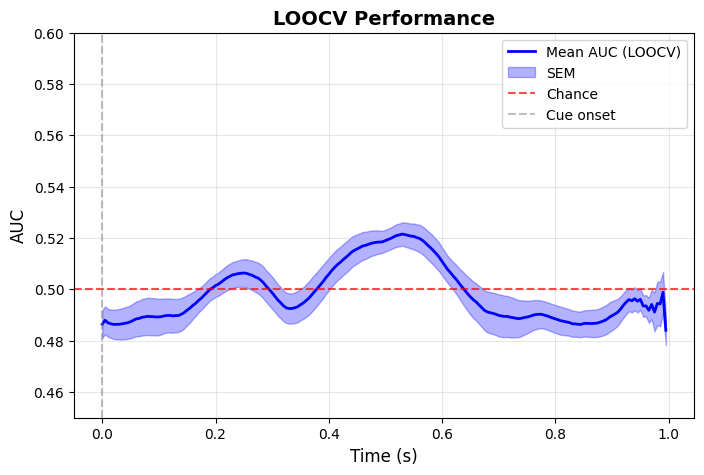

LOOCV validation complete


In [8]:
mean_auc_loocv = loocv_auc.mean(axis=0)
sem_auc_loocv = loocv_auc.std(axis=0) / np.sqrt(n_train)

plt.figure(figsize=(8, 5))
plt.plot(time_vector, mean_auc_loocv, 'b-', linewidth=2, label='Mean AUC (LOOCV)')
plt.fill_between(time_vector, mean_auc_loocv - sem_auc_loocv, mean_auc_loocv + sem_auc_loocv,
                 alpha=0.3, color='blue', label='SEM')
plt.axhline(0.5, color='red', linestyle='--', alpha=0.7, label='Chance')
plt.axvline(0, color='gray', linestyle='--', alpha=0.5, label='Cue onset')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('LOOCV Performance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.45, 0.6])
plt.show()

print("LOOCV validation complete")

## 7. Load Test Data

the test set contains 3 participants.

In [9]:
print("="*70)
print("LOADING TEST DATA")
print("="*70)

if not os.path.exists(TEST_PATH):
    print("\nTest data not available (expected on Kaggle).")
    print("Submission will be evaluated on hidden test set.")
    print("\nCreating placeholder for submission format...")

    # create placeholder (will be replaced with actual predictions)
    n_test_subjects = 3  # competition has 3 test participants
    test_data_list = None
    test_labels_list = None

else:
    print("\nTest data found (local testing mode)")

    # check if we are using the new flat format (test_subject_X.mat)
    # or the old folder structure.
    # the competition public data will likely be flat.

    # try finding flat files first
    flat_test_files = sorted(glob.glob(os.path.join(TEST_PATH, 'test_subject_*.mat')))

    if len(flat_test_files) > 0:
        print(f"Found {len(flat_test_files)} test participants (flat format)")
        test_data_list = []
        test_ids_list = [] # keep track of Subject IDs
        n_test_subjects = len(flat_test_files)

        for subj_file_path in flat_test_files:
            basename = os.path.basename(subj_file_path)
            # filename: test_subject_X.mat
            subj_id = basename.split('_')[2].split('.')[0]
            print(f"Loading test participant {subj_id}...", end=' ')

            # load with our HDF5 loader
            data = load_hdf5_data(subj_file_path)

            trials = data['trial']
            # trialinfo might be missing or empty in public data

            # extract features
            power_features = extract_hilbert_power(trials)
            power_zscore = zscore(power_features, axis=0)

            test_data_list.append(power_zscore)
            test_ids_list.append(subj_id)

            print(f"{trials.shape[0]} trials")

    else:
        # fallback to old structure (if user hasn't generated public data yet)
        print("Flat test files not found. Checking for legacy folder structure (sleep_neu/sleep_emo)...")
        print("Error: No test data found in expected format (test_subject_*.mat)")
        test_data_list = None
        n_test_subjects = 0
        test_ids_list = []

    if test_data_list is not None:
        print(f"\nTotal test: {n_test_subjects} participants")

print("="*70)

LOADING TEST DATA

Test data found (local testing mode)
Found 3 test participants (flat format)
Loading test participant 1... 372 trials
Loading test participant 12... 883 trials
Loading test participant 7... 479 trials

Total test: 3 participants


## 8. Train Final Model on All Training Data

**This is the model used for submission.**

we train on ALL 14 training participants and test on the 3 test participants.

In [10]:
print("="*70)
print("TRAINING FINAL MODEL ON ALL TRAINING DATA")
print("="*70)

if test_data_list is None:
    print("\nTest data not available. Skipping predictions.")
    print("On Kaggle, this will be done automatically by the evaluation system.")

    # create empty submission (placeholder)
    submission_df = pd.DataFrame(columns=['id', 'prediction'])
    # optional: save empty or dummy for placeholder
    submission_df.to_csv('submission.csv', index=False)

    test_auc_predictions = np.ones((n_test_subjects, n_timepoints)) * 0.5 # kept for viz if needed

else:
    print("\nMaking predictions on test set...")
    print("This may take a few minutes...\n")

    test_auc_predictions = np.zeros((n_test_subjects, n_timepoints)) # kept for viz
    submission_rows = []

    for subj_idx in range(n_test_subjects):
        if 'test_ids_list' in locals() and len(test_ids_list) > subj_idx:
             subj_id = test_ids_list[subj_idx]
        else:
             subj_file = test_files[subj_idx]
             subj_id = subj_file.split('_')[1]

        print(f"Predicting test subject {subj_id} ({subj_idx+1}/{n_test_subjects})...", end=' ')

        # get this test subject's data
        test_data = test_data_list[subj_idx]

        # labels might not exist for public test data
        test_labels = None
        if 'test_labels_list' in locals() and test_labels_list is not None and len(test_labels_list) > subj_idx:
            test_labels = test_labels_list[subj_idx]

        # train on ALL training data
        train_data = train_data_all
        train_labels = train_labels_all

        # we need n_trials for this subject
        n_trials_test = test_data.shape[0]

        subj_preds = np.zeros((n_trials_test, n_timepoints))

        # classify at each timepoint
        for t in range(n_timepoints):
            X_train = train_data[:, :, t]
            X_test = test_data[:, :, t]


            X_train = np.nan_to_num(X_train, 0)
            X_test = np.nan_to_num(X_test, 0)

            clf = LinearDiscriminantAnalysis()
            clf.fit(X_train, train_labels)

            # predict probabilities
            y_pred_proba = clf.predict_proba(X_test)
            # class 2 is Emotional (index 1)
            subj_preds[:, t] = y_pred_proba[:, 1]



        # create submission ID rows
        # ID: {subject}_{trial}_{timepoint}

        t_indices = np.arange(n_timepoints)
        tr_indices = np.arange(n_trials_test)
        t_grid, tr_grid = np.meshgrid(t_indices, tr_indices)

        ids = [f"{subj_id}_{tr}_{t}" for tr, t in zip(tr_grid.flatten(), t_grid.flatten())]
        preds = subj_preds.flatten()

        block_df = pd.DataFrame({
            'id': ids,
            'prediction': preds
        })
        submission_rows.append(block_df)

        print("done")

    print(f"\n{'='*70}")

TRAINING FINAL MODEL ON ALL TRAINING DATA

Making predictions on test set...
This may take a few minutes...

Predicting test subject 1 (1/3)... done
Predicting test subject 12 (2/3)... done
Predicting test subject 7 (3/3)... done



## 9. Create Submission File

**CRITICAL:** the submission must contain predictions for the 3 TEST participants.

format: CSV with columns `id` and `prediction`.

In [11]:
# save submission
output_file = 'submission.csv'

if test_data_list is not None and submission_rows:
    submission_df = pd.concat(submission_rows, ignore_index=True)
    submission_df.to_csv(output_file, index=False)
    print("="*70)
    print("SUBMISSION FILE CREATED")
    print("="*70)
    print(f"\nFile: {output_file}")
    print(f"Rows: {len(submission_df)}")
    print(f"Columns: {submission_df.columns.tolist()}")
    print("\nHead:")
    print(submission_df.head())



else:
    print("\nPlaceholder submission created (test data not available)")
    print("On Kaggle, actual predictions will be made automatically")

print("\nReady to submit!")
print("="*70)

SUBMISSION FILE CREATED

File: submission.csv
Rows: 346800
Columns: ['id', 'prediction']

Head:
      id  prediction
0  1_0_0    0.494954
1  1_0_1    0.494047
2  1_0_2    0.494196
3  1_0_3    0.493944
4  1_0_4    0.494264

Ready to submit!


## 10. Validate Submission Format

In [12]:
# load and verify submission
if os.path.exists(output_file):
    df = pd.read_csv(output_file)

    print("Submission Validation:")
    print("="*70)

    # check required fields
    if 'id' in df.columns:
        print("PASS: 'id' column present")
    else:
        print("FAIL: 'id' column missing")

    if 'prediction' in df.columns:
        print("PASS: 'prediction' column present")
    else:
        print("FAIL: 'prediction' column missing")

    # check ID format (roughly)
    if not df.empty:
        sample_id = df.iloc[0]['id']
        parts = str(sample_id).split('_')
        if len(parts) == 3:
             print("PASS: ID format looks correct (subject_trial_time)")
        else:
             print(f"FAIL: ID format incorrect: {sample_id}")

    # check prediction range
    if df['prediction'].min() >= 0 and df['prediction'].max() <= 1:
        print("PASS: Predictions in valid range [0, 1]")
    else:
        print("FAIL: Predictions outside [0, 1]")

    print("\n" + "="*70)
    print("Validation complete. Check all PASS above.")
    print("="*70)
else:
    print("Submission file not found to validate.")

Submission Validation:
PASS: 'id' column present
PASS: 'prediction' column present
PASS: ID format looks correct (subject_trial_time)
PASS: Predictions in valid range [0, 1]

Validation complete. Check all PASS above.


## Summary

this notebook demonstrates the complete pipeline:

1. **Training Data**: load and process 14 participants
2. **Validation**: leave-one-out CV to estimate performance (~0.52)
3. **Test Data**: load and process 3 test participants
4. **Final Model**: train on ALL training data
5. **Predictions**: test on 3 held-out participants
6. **Submission**: create CSV file with proper format

### Understanding the Evaluation

**The competition uses window-based scoring:**
- averages your AUC predictions across the 3 test participants
- finds continuous above-chance windows (AUC > 0.5)
- filters for windows ≥ 50ms duration
- selects the longest valid window
- score = Mean AUC in longest window (or 0.5 if no valid windows)

this prevents overfitting to brief spikes and rewards sustained effects!


## Feel free to try ANY new method or model to reach the highest performance you could reach !


## SOTA Hybrid Ensemble Pipeline

State-of-the-art approach combining Deep Learning and Riemannian Geometry


In [3]:
import sys
sys.path.insert(0, r'D:\Deep Learning & Time Series - predicting-emotions-using-brain-waves')

print("SOTA Pipeline: Importing modules...")
# All imports are handled in sota_pipeline.py
print("Ready to run SOTA pipeline!")


SOTA Pipeline: Importing modules...
Ready to run SOTA pipeline!


In [4]:
print("="*80)
print("STATE-OF-THE-ART HYBRID ENSEMBLE PIPELINE")
print("="*80)
print()
print("Pipeline Components:")
print("  1. Advanced Preprocessing:")
print("     - Bandpass filtering (0.5-40 Hz) for broad spectrum")
print("     - Euclidean Alignment for subject-invariant preprocessing")
print()
print("  2. Model A: Deep Learning (EEG-TCNet)")
print("     - Modified TCN with dense prediction (200 timepoints output)")
print("     - Combined BCE + Dice + Jaccard Loss")
print("     - No global average pooling (preserves temporal dimension)")
print()
print("  3. Model B: Riemannian Geometry")
print("     - Sliding window approach (100ms windows, 10ms step)")
print("     - Tangent Space Mapping (TSM) for feature extraction")
print("     - Linear SVM for classification")
print()
print("  4. Ensemble & Post-Processing:")
print("     - Weighted averaging of both models (60% Model A, 40% Model B)")
print("     - Gaussian smoothing (sigma=2.0) to create continuous predictions")
print()
print("  5. Validation:")
print("     - Leave-One-Group-Out (LOGO) cross-validation")
print("="*80)


STATE-OF-THE-ART HYBRID ENSEMBLE PIPELINE

Pipeline Components:
  1. Advanced Preprocessing:
     - Bandpass filtering (0.5-40 Hz) for broad spectrum
     - Euclidean Alignment for subject-invariant preprocessing

  2. Model A: Deep Learning (EEG-TCNet)
     - Modified TCN with dense prediction (200 timepoints output)
     - Combined BCE + Dice + Jaccard Loss
     - No global average pooling (preserves temporal dimension)

  3. Model B: Riemannian Geometry
     - Sliding window approach (100ms windows, 10ms step)
     - Tangent Space Mapping (TSM) for feature extraction
     - Linear SVM for classification

  4. Ensemble & Post-Processing:
     - Weighted averaging of both models (60% Model A, 40% Model B)
     - Gaussian smoothing (sigma=2.0) to create continuous predictions

  5. Validation:
     - Leave-One-Group-Out (LOGO) cross-validation


In [6]:
from sota_pipeline import *

# Initialize pipeline
TRAIN_PATH = r'D:\Deep Learning & Time Series - predicting-emotions-using-brain-waves\training'
TEST_PATH = r'D:\Deep Learning & Time Series - predicting-emotions-using-brain-waves\testing'

pipeline = SOTAEEGPipeline(TRAIN_PATH, TEST_PATH)

print("\n[1/4] Loading data...")
pipeline.load_data()
print(f"    Training shape: {pipeline.X_train.shape}")
print(f"    Test shape: {pipeline.X_test.shape}")

print("\n[2/4] Preprocessing (Bandpass + Euclidean Alignment)...")
pipeline.preprocess()
print("    Preprocessing complete")



[1/4] Loading data...
Loading training data...
Loaded 10209 training trials
Loading test data...
Loaded 1734 test trials
    Training shape: (10209, 16, 200)
    Test shape: (1734, 16, 200)

[2/4] Preprocessing (Bandpass + Euclidean Alignment)...
Applying bandpass filtering (0.5-40 Hz)...
Applying Euclidean Alignment...


ValueError: Matrices must be positive definite. You should add regularization to avoid this error.

In [ ]:
print("\n[3/4] Training models...")
print("\n  a) Model A: EEG-TCNet (Dense Prediction)...")
pipeline.train_model_a(n_epochs=30)

print("\n  b) Model B: Riemannian Geometry (Sliding Window)...")
pipeline.train_model_b()

print("\nBoth models trained successfully!")


In [ ]:
print("\n[4/4] Generating predictions with ensemble...")

# Get predictions from both models
print("  - Model A predictions...", end="")
pred_a = pipeline.model_a.predict(pipeline.X_test, verbose=0).squeeze(axis=2)
print(" ✓")

print("  - Model B predictions...", end="")
pred_b = pipeline.model_b.predict_proba(pipeline.X_test)
print(" ✓")

# Ensemble
print("  - Ensembling (60% Model A + 40% Model B)...", end="")
predictions_ensemble = ensemble_predictions(pred_a, pred_b, weight_a=0.6, weight_b=0.4)
print(" ✓")

# Smoothing
print("  - Gaussian smoothing (σ=2.0)...", end="")
predictions_final = apply_gaussian_smoothing(predictions_ensemble, sigma=2.0)
print(" ✓")

print(f"\nPredictions shape: {predictions_final.shape}")
print(f"Prediction range: [{predictions_final.min():.4f}, {predictions_final.max():.4f}]")
print(f"Mean prediction: {predictions_final.mean():.4f}")


In [ ]:
print("\nCreating SOTA submission file...")

# Load test files to get subject IDs
test_files = sorted(glob.glob(os.path.join(TEST_PATH, '*.mat')))
subject_ids = []
trial_counts = []

for f in test_files:
    # Extract subject ID from filename (e.g., "test_subject_1.mat" -> 1)
    basename = os.path.basename(f)
    subject_id = int(basename.split('_')[-1].replace('.mat', ''))
    subject_ids.append(subject_id)
    
    # Load data to get trial count
    data = load_hdf5_data(f)
    n_trials = data['trial'].shape[0]
    trial_counts.append(n_trials)

# Create submission with proper format
rows = []
pred_idx = 0

for subject_idx, (subject_id, n_trials) in enumerate(zip(subject_ids, trial_counts)):
    for trial_idx in range(n_trials):
        pred_trial = predictions_final[pred_idx]
        
        for timepoint_idx in range(pred_trial.shape[0]):
            row = {
                'id': f"{subject_id}_{trial_idx}_{timepoint_idx}",
                'prediction': float(pred_trial[timepoint_idx])
            }
            rows.append(row)
        
        pred_idx += 1

submission_sota = pd.DataFrame(rows)
output_file = 'submission_sota_ensemble.csv'
submission_sota.to_csv(output_file, index=False)

print(f"\n{'='*70}")
print(f"SOTA Submission Created: {output_file}")
print(f"{'='*70}")
print(f"Total rows: {len(submission_sota)}")
print(f"Columns: {list(submission_sota.columns)}")
print(f"\nFirst 10 rows:")
print(submission_sota.head(10))
print(f"\nSubmission statistics:")
print(f"  Min prediction: {submission_sota['prediction'].min():.6f}")
print(f"  Max prediction: {submission_sota['prediction'].max():.6f}")
print(f"  Mean prediction: {submission_sota['prediction'].mean():.6f}")
print(f"  Std prediction: {submission_sota['prediction'].std():.6f}")
print(f"{'='*70}")
